Stackline technical interview

Roshan Ramkeesoon

2/14/19

# Predicting product category from product details

Summary of steps:
1. Explore data
2. Feature selection and vectorization
3. Choose model by evaluating on cross validation
4. Make predictions using chosen model

In [5]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import scipy.sparse as sp

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier as RandFor
from sklearn.neural_network import MLPClassifier

TRAIN_FN = 'train.csv'
LABEL_FN = 'labels.csv'
PREDICT_FN = 'predict.csv'

## 1. Explore data

In [4]:
print('number of examples in train file: ', len(open(TRAIN_FN, 'r').readlines()))
print('number of categories in label file: ', len(open(LABEL_FN, 'r').readlines()))
print('number of examples in predict file: ', len(open(PREDICT_FN, 'r').readlines()))

number of examples in train file:  6035
number of categories in label file:  63
number of examples in predict file:  57031


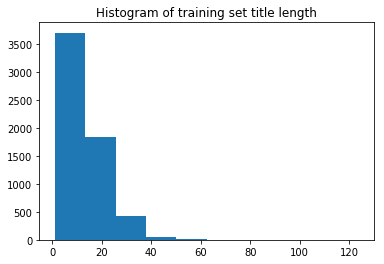

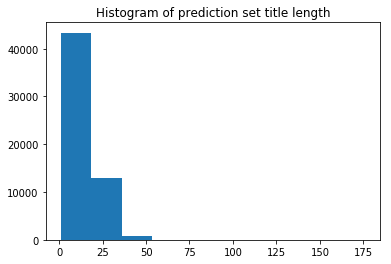

In [24]:
plt.hist([len(x['Title'].split()) for x in csv.DictReader(open(TRAIN_FN, 'r'))])
plt.title("Histogram of training set title length")
plt.show()

plt.hist([len(x['Title'].split()) for x in csv.DictReader(open(PREDICT_FN, 'r'))])
plt.title("Histogram of prediction set title length")
plt.show()

Number of words per title appears to be concetrated in the 0 to 20 words range with right tail. Distribution appears to be the same in the prediction set as in the training set which supports the hypothesis that we can train on the training set and predict on the prediction set. 

However, note that the titles are, on average, very short. This will likely present a challenge in making accurate predictions. This also makes me think that since we have a few short descriptions, we should focus on building a model that trains on a vectorized embedding of keywords in the text as opposed to using some kind of neural net that interprets the sequence of words. Neural nets that interpret sequences of words such as RNN's and CNN's can outperform less sophisticated models, but generally require a lot more parameters to be trained which means more data. 

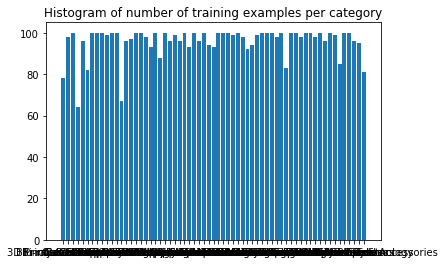

In [86]:
label_counts = defaultdict(int)
with open(TRAIN_FN, 'r') as f:
    freader = csv.DictReader(f)
    for line in freader:
        label_counts[line['CategoryName']] += 1

x = sorted(label_counts.keys())
y = [label_counts[i] for i in x]

plt.bar(x,y)
plt.title("Histogram of number of training examples per category")
plt.show()


Number of examples per category seems roughly equal across all categories in training set. This supports the hypothesis that the training set will be useful in learning to make predictions in the prediction set where the distribution of examples across categories is unknown, by learning useful features across all categories.

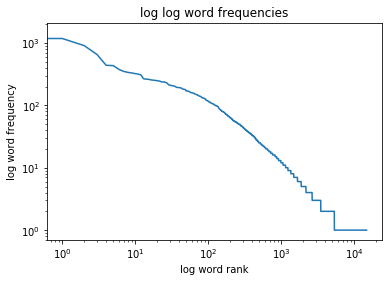

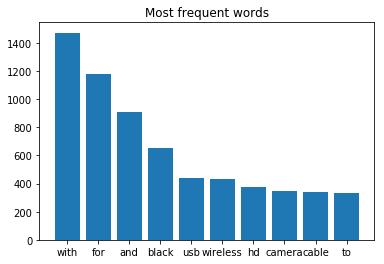

In [136]:
word_counts = defaultdict(int)
with open(TRAIN_FN, 'r') as f:
    freader = csv.DictReader(f)
    for line in freader:
        for word in line['Title'].split():
            word = word.lower().strip(',').strip('.').strip('!').strip('/').strip('-')
            if word:
                word_counts[word] += 1

x = sorted(word_counts, key=word_counts.get, reverse=True)
y = [word_counts[i] for i in x]

# plt.bar(range(len(x)),y, tick_label=x)
plt.loglog(range(len(x)),y,basex=10)
plt.title("log log word frequencies")
plt.xlabel('log word rank')
plt.ylabel('log word frequency')
plt.show()


plt.bar(range(10),y[:10],tick_label=x[:10])
plt.title("Most frequent words")
plt.show()

According to zipf's law we expect the log log plot of word rank and word frequency to appear approximately linear. We see this is the case.

We see a few of the most frequent words are conjunctions which could likely be excluded from future analysis. The presence of "wireless" and "usb" leads me to believe there is a technology bias in the products.

## 2. Feature selection and vectorization
Treat the brand and text separately. 

Onehotify the brand since there are only a few in the dataset. 

On the text, identify all unigrams and bigrams. Use f_classif which uses ANOVA F-statistic to find the k top ngrams which are responsible for explaining the most observed variance in the data. Vectorize the text as bag of words on the top k features and where the values are the tfidf weighted values in the corpus.

In [6]:
with open(TRAIN_FN, 'rU') as f:
    freader = csv.DictReader(f)
    brands = sorted(set([x['BrandName'] for x in freader]))
    print('There are {} number of unique brands in training set.'.format(len(brands)))


def onehotify_brand(example_brands):
    out = []
    for b in example_brands:
        v = np.zeros(len(brands))
        if b in brands:
            v[brands.index(b)] = 1
        out.append(v)
    return sp.csr_matrix(out)

There are 1480 number of unique brands in training set.


/Users/roshanramkeesoon/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


In [12]:
TOPK = 1500

def get_ngram_embeddings(train_texts, train_labels, val_texts):
    vectorizer = TfidfVectorizer(ngram_range = (1, 2), # look at unigrams and bigrams
                                strip_accents = 'unicode',
                                decode_error = 'replace',
                                analyzer = 'word',
                                min_df = 2)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOPK, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val, vectorizer, selector

def process_text(text):
    return ' '.join([w.lower().strip(',').strip('.').strip('!').strip('/').strip('-') for w in text.split()])

## 3. Choose model by evaluating on cross validation

Use naive bayes with multinomial distribution for making predictions using discrete features such as word frequencies. It also works well in practice if we use tfidf scores which aren't discrete. I chose this model as a simple baseline because in practice it often works very well with small datasets.

Use the built in multilayer perceptron in sklearn to test performance of a simple feed forward neural net against naive bayes. Chose 3-layers because most feed forward nn's can learn text classification tasks with such architecture. Chose number of nodes per layer so that the network is wider at the base to process high dimension input and narrower at the top to output to lower dimension layer space. Chose 5 partitions for cross validation because it provides 20% validation on each iteration which is enough that the validation is useful but not so much that it hinders training.

In [13]:
def top_n_accuracy(predictions, trues, n):
    best_n = np.argsort(predictions, axis=1)[:,-n:]
    ts = np.argmax(trues, axis=1)
    successes = 0
    for i in range(ts.shape[0]):
      if ts[i] in best_n[i,:]:
        successes += 1
    return float(successes)/ts.shape[0]

In [14]:
X_title = []
X_brand = []
Y = []
n_examples = 0        

with open('train.csv', 'r') as f:
    freader = csv.DictReader(f)
    for line in freader:
        X_title.append(process_text(line['Title']))
        X_brand.append(line['BrandName'])
        Y.append(line['CategoryName'])
        n_examples += 1
        
N_PARTITIONS = 5
SHUFFLE = True

width = n_examples//N_PARTITIONS

if SHUFFLE:
    random.shuffle(list(zip(X_title, X_brand, Y)))

scores = {'nb':[], 'mlp':[]}
topk = {'nb':[], 'mlp':[]}

for i in range(N_PARTITIONS):
    print('working on partition {}'.format(i))

    X_title_train = X_title[:i*width] + X_title[(i+1)*width:]
    X_brand_train = X_brand[:i*width] + X_brand[(i+1)*width:]
    Y_train = Y[:i*width] + Y[(i+1)*width:]

    X_title_val = X_title[i*width:(i+1)*width]
    X_brand_val = X_brand[i*width:(i+1)*width]
    Y_val = Y[i*width:(i+1)*width]
    
    X_title_train, X_title_val, vectorizer, selector = get_ngram_embeddings(X_title_train, Y_train, X_title_val)
    X_brand_train = onehotify_brand(X_brand_train)
    X_brand_val = onehotify_brand(X_brand_val)
    
    X_train = sp.hstack([X_title_train, X_brand_train])
    X_val = sp.hstack([X_title_val, X_brand_val])
    
    NBModel = MultinomialNB()
    NBModel.fit(X_train, Y_train)
    scores['nb'].append(NBModel.score(X_val, Y_val))
    
    Y_pred = NBModel.predict_proba(X_val)
    Y_true = [[1 if y==j else 0 for j in NBModel.classes_] for y in Y_val]
    topk['nb'].append(top_n_accuracy(Y_pred, Y_true, n=3))
    
    MLPModel = MLPClassifier(activation='relu', alpha=1e-05, batch_size=128,
                hidden_layer_sizes=(128, 96, 64),
              learning_rate='constant', learning_rate_init=0.001,
              max_iter=500, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5,
              shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.0, verbose=False, warm_start=False)
    MLPModel.fit(X_train, Y_train)
    scores['mlp'].append(MLPModel.score(X_val, Y_val))

    Y_pred = MLPModel.predict_proba(X_val)
    Y_true = [[1 if y==j else 0 for j in MLPModel.classes_] for y in Y_val]
    topk['mlp'].append(top_n_accuracy(Y_pred, Y_true, n=3))
    
print('\nACCURACY')
print('Partition validation accuracy are: ', scores)
for model in scores:
    print('Mean partition validation score for {}: {}'.format(model.upper(), np.mean(scores[model])))

print('\nTOP 3 ACCURACY')
print('Partition validation accuracy are: ', topk)
for model in  topk:
    print('Mean partition validation score for {}: {}'.format(model.upper(), np.mean(topk[model])))

working on partition 0
working on partition 1
working on partition 2
working on partition 3
working on partition 4

ACCURACY
Partition validation accuracy are:  {'nb': [0.6285240464344942, 0.5771144278606966, 0.6948590381426202, 0.6276948590381426, 0.7006633499170812], 'mlp': [0.6451077943615257, 0.6235489220563848, 0.7056384742951907, 0.6235489220563848, 0.6890547263681592]}
Mean partition validation score for NB: 0.6457711442786069
Mean partition validation score for MLP: 0.6573797678275289

TOP 3 ACCURACY
Partition validation accuracy are:  {'nb': [0.7379767827529021, 0.7611940298507462, 0.8424543946932007, 0.7728026533996684, 0.8225538971807629], 'mlp': [0.7669983416252073, 0.7570480928689884, 0.8043117744610282, 0.7520729684908789, 0.7927031509121062]}
Mean partition validation score for NB: 0.7873963515754561
Mean partition validation score for MLP: 0.7746268656716419


## 4. Make predictions using chosen model
Both models have similar performance after hyperparameter tuning. Go with the simpler, more explainable model: the naive bayes model. Retrain the chosen model on the entire training set to maximize learning.

In [20]:
X_title = []
X_brand = []
Y = []
n_examples = 0        

with open('train.csv', 'r') as f:
    freader = csv.DictReader(f)
    for line in freader:
        X_title.append(process_text(line['Title']))
        X_brand.append(line['BrandName'])
        Y.append(line['CategoryName'])
        n_examples += 1
    
X_title = vectorizer.transform(X_title)
X_title = selector.transform(X_title).astype('float32')
X_brand = onehotify_brand(X_brand)
X_train = sp.hstack([X_title, X_brand])

NBModel = MultinomialNB()
NBModel.fit(X_train, Y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [30]:
with open('predict.csv', 'r') as f:
    freader = csv.reader(f)
    
    for row in freader:
        process_text(row[2])
        onehotify_brand(row[1])
        
X_title = []
X_brand = []

with open('predict.csv', 'r') as f:
    freader = csv.DictReader(f)
    for line in freader:
        X_title.append(process_text(line['Title']))
        X_brand.append(line['BrandName'])
        
X_title = vectorizer.transform(X_title)
X_title = selector.transform(X_title).astype('float32')
X_brand = onehotify_brand(X_brand)
X = sp.hstack([X_title, X_brand])

Y = NBModel.predict(X)

g = open('predict_out.csv', 'w')
gwriter = csv.writer(g)

with open('predict.csv', 'r') as f:
    freader = csv.reader(f)
    headers = next(freader)
    headers.append('PredictedCategory')
    gwriter.writerow(headers)
    
    for row, y in zip(freader, Y):  
        row.append(y)
        gwriter.writerow(row)
        
g.close()